In [23]:
import math

import cufflinks as cf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPYNBrenderer import render_google_doc
from tensorflow import keras
import tensorflow as tf
cf.go_offline(connected=True)

$$ \ s_{current} = s +  (\frac{\partial c}{\partial w _{((w)}})^2 

$$ \ w_{new} = w_{current} - \eta (\frac{\partial c}{\partial w _{((w)}}) * \sqrt{(s_{current} + \epsilon)}

In [2]:
def MSE_loss(target_y, predicted_y):
  error = target_y - predicted_y
  squared_error = tf.square(error)
  mse = tf.reduce_mean(squared_error)
  return mse

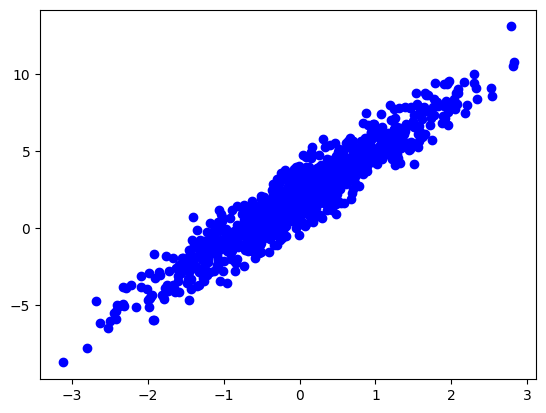

In [24]:
TRUE_W = 3.0
TRUE_B = 2.0

NUM_EXAMPLES = 1000


x = tf.random.normal(shape=[NUM_EXAMPLES])
noise = tf.random.normal(shape=[NUM_EXAMPLES])
y = x * TRUE_W + TRUE_B + noise

plt.scatter(x, y, c='b')

In [4]:
class MyModel(tf.Module):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)

    # initial weights
    self.w = tf.Variable(5.0) # TRUE_W = 3.0
    self.b = tf.Variable(0.0) # TRUE_B = 2.0
    self.w_s = tf.Variable(0.0)
    self.b_s =  tf.Variable(0.0)

  def __call__(self, x):
    return (self.w*x + self.b)

In [5]:
model = MyModel()

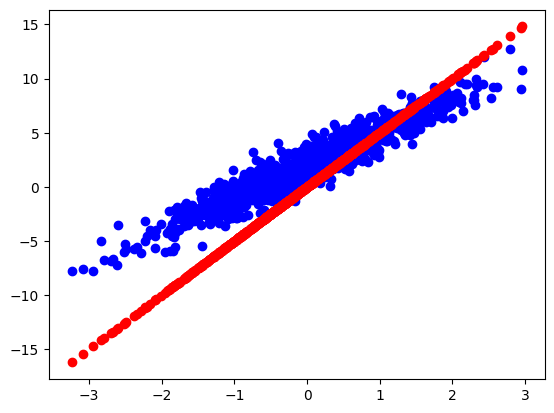

In [6]:
plt.scatter(x, y, c="b")

pred_y = model(x) # its an untrained model
plt.scatter(x, pred_y, c="r")

plt.show()


In [7]:
def adam_optimizer_train(model, x, y, learning_rate , epsilon=1e-5):

  with tf.GradientTape(persistent=True) as tape:
    y_hat= model(x)
    current_loss = MSE_loss(y, y_hat)

  dc_dw, dc_db = tape.gradient(current_loss, [model.w, model.b])
  sw_new = model.w_s + tf.square(dc_dw)
  sb_new = model.b_s + tf.square(dc_db)

  model.w.assign_sub((learning_rate*dc_dw ) / tf.sqrt(sw_new + epsilon)) 
  model.b.assign_sub((learning_rate*dc_db) / tf.sqrt(sw_new + epsilon)) 
  model.b_s.assign(sb_new)
  model.w_s.assign(sw_new)
  return current_loss

In [8]:
model = MyModel()

Ws, bs , sw , sb  = list(), list() , list() , list()
LOSS = list()
epochs = 20

learning_rate = 0.9 # LARGE LEARNING RATE

w = model.w.numpy()
b = model.b.numpy()

init_loss = MSE_loss(y, model(x)).numpy()

print(f"initial W: {w}, initial_bias: {b}, initial loss: {init_loss}")

initial W: 5.0, initial_bias: 0.0, initial loss: 9.222919464111328


In [9]:
for epoch in range(epochs):
  adam_optimizer_train(model, x, y, learning_rate )

  Ws.append(model.w.numpy())
  bs.append(model.b.numpy())
  sw.append(model.w_s.numpy())
  sb.append(model.b_s.numpy())
  current_loss = MSE_loss(y, model(x))
  LOSS.append(current_loss.numpy())

  print(f"For epoch: {epoch}, W: {Ws[-1]}, bias: {bs[-1]}, current loss: {current_loss}")

For epoch: 0, W: 4.100000381469727, bias: 0.8865182995796204, current loss: 3.556411027908325
For epoch: 1, W: 3.6661479473114014, bias: 1.321578860282898, current loss: 1.972245216369629
For epoch: 2, W: 3.413823366165161, bias: 1.5782610177993774, current loss: 1.4003536701202393
For epoch: 3, W: 3.259289503097534, bias: 1.7375993728637695, current loss: 1.1788216829299927
For epoch: 4, W: 3.162912368774414, bias: 1.8382976055145264, current loss: 1.0908414125442505
For epoch: 5, W: 3.102390766143799, bias: 1.9023723602294922, current loss: 1.055564045906067
For epoch: 6, W: 3.064283609390259, bias: 1.9432529211044312, current loss: 1.0413645505905151
For epoch: 7, W: 3.040264844894409, bias: 1.9693634510040283, current loss: 1.0356395244598389
For epoch: 8, W: 3.0251200199127197, bias: 1.9860477447509766, current loss: 1.033329725265503
For epoch: 9, W: 3.0155692100524902, bias: 1.9967108964920044, current loss: 1.0323973894119263
For epoch: 10, W: 3.0095460414886475, bias: 2.003526

In [10]:
data = pd.DataFrame({"W": Ws, "b": bs, "sw": sw, "sb": sb})

In [11]:
data["w_true"] = TRUE_W
data["b_true"] = TRUE_B

In [12]:
data['epoch'] = range(epochs)
data['loss'] = LOSS

In [13]:
data.iplot(kind="scatter" , x="epoch", y=["W" , "b" , "w_true" , "b_true"], mode="lines+markers", title="W vs epoch")

In [17]:
data.iplot(kind="scatter" , x="epoch", y=["loss" , "W" , "b"], mode="lines+markers", title="W vs epoch")

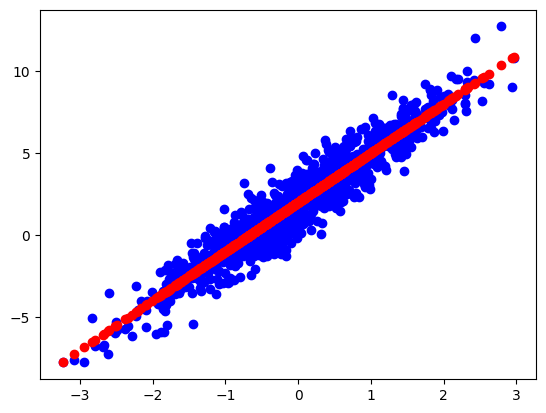

In [18]:
plt.scatter(x, y, c="b")

pred_y = model(x) # its an untrained model
plt.scatter(x, pred_y, c="r")

plt.show()

In [20]:
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full
X_test = X_test 
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [21]:
import os


TENSOR_LOG_PATH = os.path.join(os.getcwd() , "TENSOR_BOARD_LOG")
os.makedirs(TENSOR_LOG_PATH , exist_ok=True )

In [22]:
%%timeit
LAYERS = [ tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(300, kernel_initializer="he_normal"),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, kernel_initializer="he_normal"),
    tf.keras.layers.LeakyReLU(),
    
    tf.keras.layers.Dense(10, activation="softmax")]
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=2,mode="min" ,monitor='val_loss',restore_best_weights=True)
tensorboard_cb = tf.keras.callbacks.TensorBoard(TENSOR_LOG_PATH)
model_normalized_batch= tf.keras.models.Sequential(LAYERS)
OPTIMIZER = tf.keras.optimizers.Adagrad(learning_rate=0.001,initial_accumulator_value=0.1,epsilon=1e-07,name='Adagrad')
model_normalized_batch.compile(loss="sparse_categorical_crossentropy", optimizer=OPTIMIZER , metrics=["accuracy"])
history = model_normalized_batch.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid), callbacks=[early_stopping_cb])

Epoch 1/30
   9/1719 [..............................] - ETA: 25s - loss: 2.7348 - accuracy: 0.1424 

2022-10-23 22:41:56.316501: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1719/1719 [==============================] - 28s 15ms/step - loss: 0.6957 - accuracy: 0.7598 - val_loss: 0.5170 - val_accuracy: 0.8268
Epoch 2/30
1719/1719 [==============================] - 27s 16ms/step - loss: 0.5155 - accuracy: 0.8194 - val_loss: 0.4604 - val_accuracy: 0.8412
Epoch 3/30
1719/1719 [==============================] - 27s 16ms/step - loss: 0.4766 - accuracy: 0.8306 - val_loss: 0.4390 - val_accuracy: 0.8480
Epoch 4/30
1719/1719 [==============================] - 27s 16ms/step - loss: 0.4549 - accuracy: 0.8385 - val_loss: 0.4241 - val_accuracy: 0.8524
Epoch 5/30
1719/1719 [==============================] - 27s 16ms/step - loss: 0.4395 - accuracy: 0.8447 - val_loss: 0.4096 - val_accuracy: 0.8572
Epoch 6/30
1719/1719 [==============================] - 27s 16ms/step - loss: 0.4291 - accuracy: 0.8483 - val_loss: 0.4082 - val_accuracy: 0.8592
Epoch 7/30
1719/1719 [==============================] - 27s 16ms/step - loss: 0.4207 - accuracy: 0.8507 - val_loss: 0.3968 - val_accura

#### Drawbacks 
1. it often stops early before reaching the global minima 
2. longer training time to coverage  due to decaY  LEARNING RATE  
#### Advantage 
1. it corrects the direction of the gradient vector initially  unlike GD 
2. less tunning of learning rate is required because of decaying factor 

## ITS NOT RECOMMENDED TO USE   